# Support Vector Machine

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

## Loading Dataset

In [2]:
df = pd.read_csv('heart.csv')
data = df.to_numpy()

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
X_data = data[:, :-1]
y_data = data[:, -1]

## 1. Data Preprocessing

### 1.1. Splitting data

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_data,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)

In [6]:
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t' + str(X_val.shape))
print('y_val: \t' + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

X_train:(261, 13)
y_train:(261,)
X_val: 	(20, 13)
y_val: 	(20,)
X_test: (22, 13)
y_test: (22,)


### 1.2. Normalizing Features

In [7]:
# Initializing scaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

MinMaxScaler(feature_range=(-1, 1)) has a 55% accuracy on validation set

MinMaxScaler has a 45% accuracy on validation set

StandardScaler has a 75% accuracy on validation set

## 2. Trying Different Optimization Techniques

### 2.1. Pegasos (stochastic sub-gradient descent)

#### Pegasos Algorithm

In [8]:
def score(X, w):
    return X@w


def svm_objective(w, X, y, lambda1=.1):
    min_verse = lambda1/2 * w@w
    y = 1 - y*score(X, w)
    zeros = np.zeros((np.shape(y)))
    hinge_loss = np.maximum(zeros, y)
    result = np.min(min_verse) + np.sum(hinge_loss)
    return result


def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):

    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):
        # Calculate and print the objective value
#         print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range(N):
            t = t + 1
            alpha = 1 / (lambda1 * t)
            if y_train[i] * (w@X_train[i]) >= 1:
                w -= alpha * lambda1 * w
            else:
                w -= alpha * (lambda1 * w - X_train[i] * y_train[i])
        
    return w

#### Training the Pegasos algorithm on  $X_{\text{train}}$ and $y_{\text{train}}$ to get weight vector

In [9]:
lambda1 = 0.005
num_iters = 50

w = pegasos(X_train, y_train, lambda1, num_iters)
w

array([ 0.37059052, -0.21082389,  0.75894773, -0.46405325, -0.08963237,
        0.00374905,  0.07936874,  0.62022818, -0.52939569, -0.90897302,
        0.33319363, -0.99032243, -0.86425678])

#### Accuracy Estimation on the Validation Set 

In [10]:
N_val = y_val.shape[0]
threshold = 0

scores = score(X_val, w)
predictions = scores >= 0

accuracy = np.count_nonzero(predictions == y_val) / N_val
print('Accuracy: {}%'.format(accuracy * 100))

Accuracy: 70.0%


### 2.2. Kernel Functions

In [11]:
# Define the subset size
subset_size = 50

# Take a subset of the original dataset
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]
X_val_subset, y_val_subset = X_val[:subset_size], y_val[:subset_size]
X_test_subset, y_test_subset = X_test[:subset_size], y_test[:subset_size]

In [12]:
# Initialize SVC with linear kernel
svm_linear = SVC(kernel='linear', C=1E10)  # Choosing C to be large to ensure no misclassification points
svm_linear.fit(X_train_subset, y_train_subset)
y_pred_linear = svm_linear.predict(X_val_subset)
accuracy_linear = accuracy_score(y_val_subset, y_pred_linear)
print("Accuracy with Linear Kernel:", accuracy_linear)

Accuracy with Linear Kernel: 0.85


In [13]:
# Initialize SVC with polynomial kernel
svm_poly = SVC(kernel='poly', degree=3)  # You can adjust the degree parameter
svm_poly.fit(X_train_subset, y_train_subset)
y_pred_poly = svm_poly.predict(X_val_subset)
accuracy_poly = accuracy_score(y_val_subset, y_pred_poly)
print("Accuracy with Polynomial Kernel:", accuracy_poly)

Accuracy with Polynomial Kernel: 0.75


In [14]:
# Initialize SVC with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1E6)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_val)
accuracy_rbf = accuracy_score(y_val, y_pred_rbf)
print("Accuracy with RBF Kernel:", accuracy_rbf)


Accuracy with RBF Kernel: 0.75


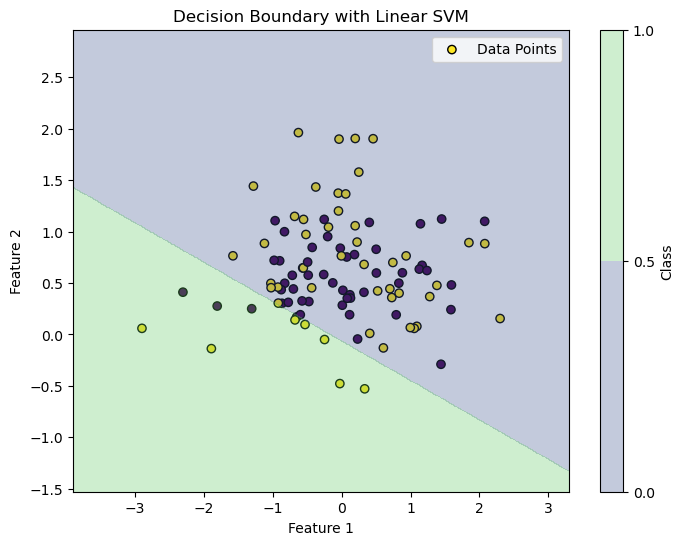

In [18]:
# Select two features for visualization
feature1_index = 0
feature2_index = 1
selected_features = [feature1_index, feature2_index]  # Replace with the indices of the two features you want to use

# Retain only the selected features from the training data
X_train_selected = X_train_subset[:, selected_features]

# Train a new SVM model using only the selected features
svm_linear_selected = SVC(kernel='linear', C=1E10)
svm_linear_selected.fit(X_train_selected, y_train_subset)

# Generate synthetic 13-dimensional dataset
X, y = make_classification(n_samples=100, n_features=13, n_classes=2, n_clusters_per_class=1, random_state=42)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[:, feature1_index], X[:, feature2_index], c=y, cmap='viridis', marker='o', edgecolors='k', label='Data Points')

# Create a mesh grid to plot decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, feature1_index].min() - 1, X[:, feature1_index].max() + 1, 500),
                     np.linspace(X[:, feature2_index].min() - 1, X[:, feature2_index].max() + 1, 500))
Z = svm_linear_selected.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis', levels=[0, 0.5, 1])
plt.colorbar(label='Class')

plt.xlabel(f'Feature {feature1_index + 1}')
plt.ylabel(f'Feature {feature2_index + 1}')
plt.title('Decision Boundary with Linear SVM')
plt.legend()
plt.show()